# Double Jet

Analysing negative Eigenvalues

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

Two-level ensemble

In [5]:
ls = [6, 7, 8]

In [6]:
from gpuocean.utils import DoubleJetCase

args_list = []
init_list = []

for l in ls:
    doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=2**l, nx=2**(l+1))
    doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

    args_list.append(doubleJetCase_args)
    init_list.append(doubleJetCase_init)

In [7]:
source_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/crash_reports/2023-09-20T17_02_52"

In [8]:
## MultiLevel ensemble
ML_state = []

ML_state.append(np.load(source_path+"/MLensemble_0.npy"))

numLevels = len(set([f.split("_")[1][0] for f in os.listdir(source_path)]))
for l_idx in range(1, numLevels):
    ML_state.append( [np.load(source_path+"/MLensemble_"+str(l_idx)+"_0.npy"), np.load(source_path+"/MLensemble_"+str(l_idx)+"_1.npy")] )

In [9]:
ML_Ne = []

ML_Ne.append(ML_state[0].shape[-1])
for l_idx in range(1, numLevels):
    ML_Ne.append(ML_state[l_idx][0].shape[-1])
ML_Ne

[12, 22, 24]

In [10]:
from utils.DoubleJetParametersReplication import *

In [11]:
from utils.DoubleJetEnsembleInit import *
ML_ensemble = initMLensemble(ML_Ne, args_list, init_list,
                             sim_model_error_basis_args=sim_model_error_basis_args, 
                             sim_model_error_time_step=sim_model_error_timestep)

0
1
2


In [12]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [13]:
MLOceanEnsemble.upload(ML_state)

In [14]:
from gpuocean.dataassimilation import MLEnKFOcean
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)

Read observation label manually from log file (not in crash reports...)

In [15]:
h = 8

In [16]:
obs_x, obs_y = obs_xs[h], obs_ys[h]

Investigate

In [17]:
from utils.DoubleJetPlot import *

In [18]:
obs_idxs = [list(np.unravel_index(np.argmin((MLEnKF.lvl_X[0] - obs_x)**2 + (MLEnKF.lvl_Y[0] - obs_y)**2), ML_state[0][0].shape[:-1]))]
for l_idx in range(1, len(ML_Ne)):
    obs_idxs0 = np.unravel_index(np.argmin((MLEnKF.lvl_X[l_idx]   - obs_x)**2 + (MLEnKF.lvl_Y[l_idx]   - obs_y)**2), ML_state[l_idx][0][0].shape[:-1])
    obs_idxs1 = np.unravel_index(np.argmin((MLEnKF.lvl_X[l_idx-1] - obs_x)**2 + (MLEnKF.lvl_Y[l_idx-1] - obs_y)**2), ML_state[l_idx][1][0].shape[:-1])
    obs_idxs.append([list(obs_idxs0), list(obs_idxs1)])

# Number of observed variables
if obs_var.step is None:
    obs_varN = (obs_var.stop - obs_var.start) 
else: 
    obs_varN = (obs_var.stop - obs_var.start)/obs_var.step

In [19]:
ML_XY = np.zeros((np.prod(ML_state[-1][0].shape[:-1]),obs_varN))

X0 = ML_state[0]
X0mean = np.average(X0, axis=-1)

Y0 = ML_state[0][obs_var,obs_idxs[0][0],obs_idxs[0][1]] 
Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]

ML_XY += (1/(ML_Ne[0]-1) 
                  *( (X0-X0mean[:,:,:,np.newaxis]).reshape(-1,ML_Ne[0]) 
                    @ (Y0 - Y0mean).T)
                ).reshape(X0mean.shape + (obs_varN,)).repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2).reshape(-1,obs_varN)

ML_YY = 1/(ML_Ne[0]-1) *( (Y0 - Y0mean) @ (Y0 - Y0mean).T)
ML_YY

array([[68.81557529, 31.88807161],
       [31.88807161, 94.51858629]])

In [20]:
np.linalg.eigvals(ML_YY)

array([ 47.28670405, 116.04745752])

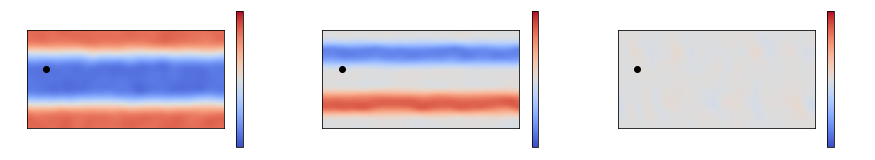

In [21]:
fig, axs = imshow3(np.mean(ML_state[0], axis=-1))
for i in range(3):
    axs[i].scatter(obs_idxs[0][1],obs_idxs[0][0], c="black")

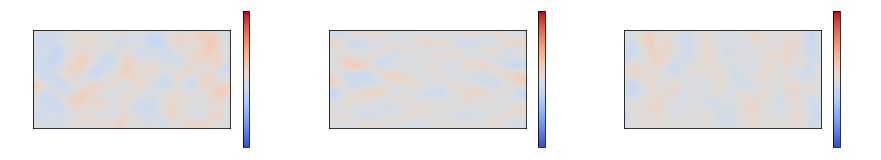

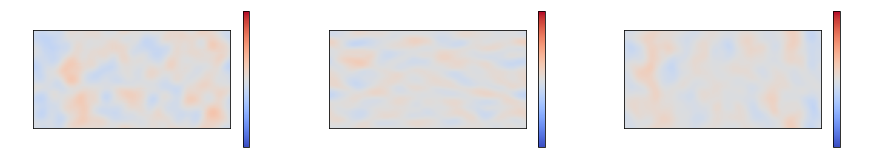

In [22]:
fig, axs = imshow3(ML_XY.reshape(ML_state[-1][0].shape[:-1]+(obs_varN,))[:,:,:,0])
fig, axs = imshow3(ML_XY.reshape(ML_state[-1][0].shape[:-1]+(obs_varN,))[:,:,:,1])

In [23]:
for l_idx in range(1,numLevels):
  X0 = ML_state[l_idx][0]
  X0mean = np.average(X0, axis=-1)
  X1 = ML_state[l_idx][1].repeat(2,1).repeat(2,2)
  X1mean = np.average(X1, axis=-1)

  Y0 = ML_state[l_idx][0][obs_var,obs_idxs[l_idx][0][0],obs_idxs[l_idx][0][1]] 
  Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]
  Y1 = ML_state[l_idx][1][obs_var,obs_idxs[l_idx][1][0],obs_idxs[l_idx][1][1]] 
  Y1mean = np.average(Y1, axis=-1)[:,np.newaxis]

  ML_XY += ( ( 1/(ML_Ne[l_idx]-1)
                      *( (X0-X0mean[:,:,:,np.newaxis]).reshape(-1,ML_Ne[l_idx]) 
                        @ (Y0 - Y0mean).T) 
                    - 1/(ML_Ne[l_idx]-1)
                      *( (X1-X1mean[:,:,:,np.newaxis]).reshape(-1,ML_Ne[l_idx]) 
                        @ (Y1 - Y1mean).T) 
                  )
              ).reshape(X0mean.shape + (obs_varN,)).repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2).reshape(-1,obs_varN)

  ML_YY +=  1/(ML_Ne[l_idx]-1) *( (Y0 - Y0mean) @ (Y0 - Y0mean).T ) \
                  - 1/(ML_Ne[l_idx]-1) *( (Y1 - Y1mean) @ (Y1 - Y1mean).T) 
  
  print("Level ", l_idx)
  print(ML_YY)
  print(np.linalg.eigvals(ML_YY))
  print(" ")

ML_YY

Level  1
[[  1.33616249  -0.78420005]
 [ -0.78420005 158.9605926 ]]
[  1.3322611  158.96449399]
 
Level  2
[[-14.79975564  -2.50692489]
 [ -2.50692489 195.91408502]]
[-14.82957705 195.94390642]
 


array([[-14.79975564,  -2.50692489],
       [ -2.50692489, 195.91408502]])

In [24]:
np.linalg.eigvals(ML_YY)

array([-14.82957705, 195.94390642])

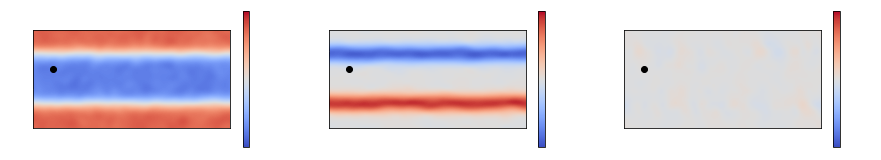

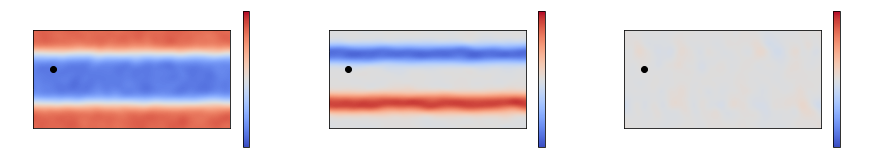

In [25]:
fig, axs = imshow3(np.mean(ML_state[l_idx][0], axis=-1))
for i in range(3):
    axs[i].scatter(obs_idxs[-1][0][1],obs_idxs[-1][0][0], c="black")

fig, axs = imshow3(np.mean(ML_state[l_idx][1], axis=-1))
for i in range(3):
    axs[i].scatter(obs_idxs[-1][1][1],obs_idxs[-1][1][0], c="black")


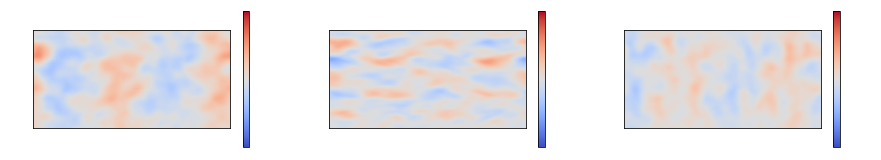

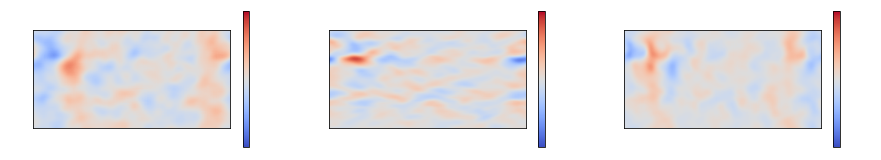

In [26]:
fig, axs = imshow3(ML_XY.reshape(ML_state[-1][0].shape[:-1]+(obs_varN,))[:,:,:,0])
fig, axs = imshow3(ML_XY.reshape(ML_state[-1][0].shape[:-1]+(obs_varN,))[:,:,:,1])

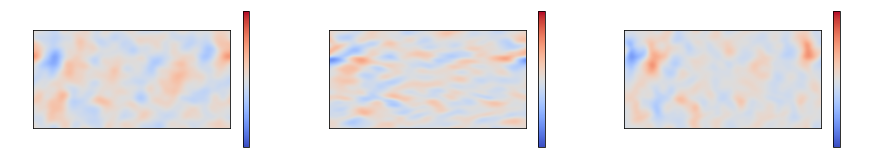

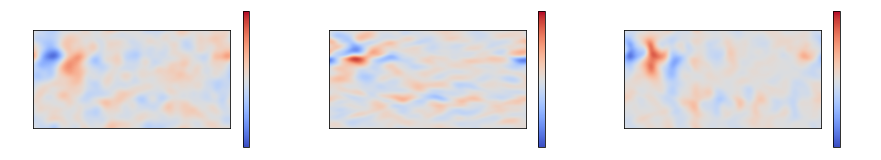

In [27]:
fineXY = (1/(ML_Ne[l_idx]-1)*( (X0-X0mean[:,:,:,np.newaxis]).reshape(-1,ML_Ne[l_idx]) @ (Y0 - Y0mean).T) ).reshape(ML_state[-1][0].shape[:-1]+(obs_varN,))
fig, axs = imshow3(fineXY.reshape(ML_state[-1][0].shape[:-1]+(obs_varN,))[:,:,:,0])
fig, axs = imshow3(fineXY.reshape(ML_state[-1][0].shape[:-1]+(obs_varN,))[:,:,:,1])

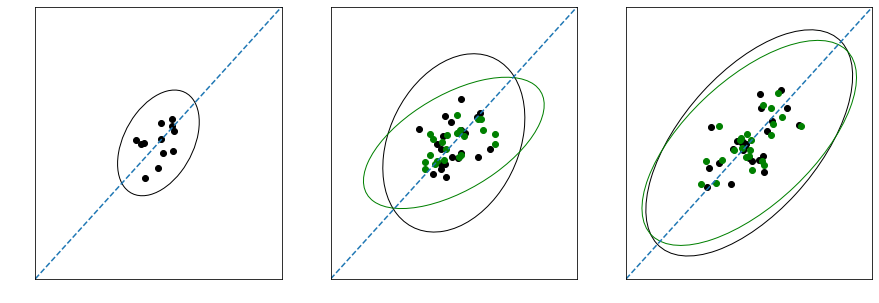

In [28]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

fig, axs = plt.subplots(1, len(ML_Ne), figsize=(15,5))

axlim = 75

def _add_ellipse(ax, Y0, edgecolor="black"):
    Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]
    ML_YY = 1/(ML_Ne[0]-1) *( (Y0 - Y0mean) @ (Y0 - Y0mean).T)

    pearson = ML_YY[0, 1]/np.sqrt(ML_YY[0, 0] * ML_YY[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor="none", edgecolor=edgecolor)
    scale_x = np.sqrt(ML_YY[0, 0]) * 3
    scale_y = np.sqrt(ML_YY[1, 1]) * 3

    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(0, 0)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Y0 = ML_state[0][obs_var,obs_idxs[0][0],obs_idxs[0][1]] 
Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]

axs[0].scatter(Y0[0]-Y0mean[0], Y0[1]-Y0mean[1], c="black")
_add_ellipse(axs[0], Y0, edgecolor="black")

for l_idx in range(1,numLevels):
    Y0 = ML_state[l_idx][0][obs_var,obs_idxs[l_idx][0][0],obs_idxs[l_idx][0][1]] 
    Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]
    Y1 = ML_state[l_idx][1][obs_var,obs_idxs[l_idx][1][0],obs_idxs[l_idx][1][1]] 
    Y1mean = np.average(Y1, axis=-1)[:,np.newaxis]

    axs[l_idx].scatter(Y0[0]-Y0mean[0], Y0[1]-Y0mean[1], c="black")
    _add_ellipse(axs[l_idx], Y0, edgecolor="black")

    axs[l_idx].scatter(Y1[0]-Y1mean[0], Y1[1]-Y1mean[1], c="green")
    _add_ellipse(axs[l_idx], Y1, edgecolor="green")

for l_idx in range(len(ML_Ne)):
    axs[l_idx].plot((-axlim,axlim), (-axlim,axlim), ls="--")
    axs[l_idx].set_xlim((-axlim,axlim))
    axs[l_idx].set_ylim((-axlim,axlim))

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


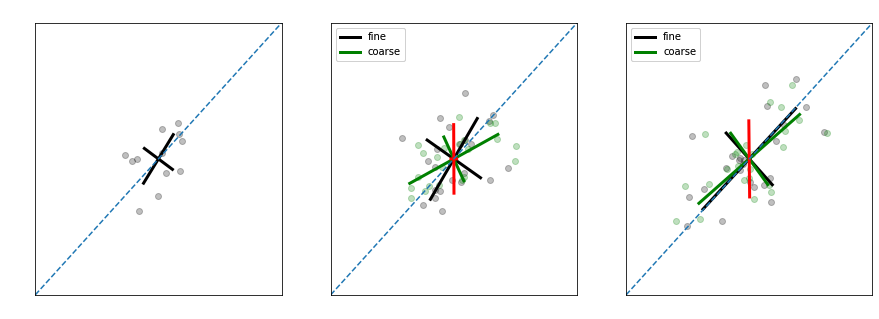

In [29]:
import matplotlib.lines as mlines

fig, axs = plt.subplots(1, len(ML_Ne), figsize=(15,5))

axlim = 50

def _add_verts(ax, Y0, linecolor="black", **kwargs):
    Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]
    ML_YY = 1/(ML_Ne[0]-1) *( (Y0 - Y0mean) @ (Y0 - Y0mean).T)
    vals, vecs = np.linalg.eig(ML_YY)

    for i in range(2):
        dir = vecs.T[i]*np.sqrt(vals[i])
        ax.plot([-dir[0], dir[0]], [-dir[1], dir[1]], c=linecolor, lw=3, **kwargs)

    return ax

Y0 = ML_state[0][obs_var,obs_idxs[0][0],obs_idxs[0][1]] 
Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]

ML_YY = 1/(ML_Ne[0]-1) *( (Y0 - Y0mean) @ (Y0 - Y0mean).T)

axs[0].scatter(Y0[0]-Y0mean[0], Y0[1]-Y0mean[1], c="black", alpha=0.25)
_add_verts(axs[0], Y0, linecolor="black")

for l_idx in range(1,numLevels):
    Y0 = ML_state[l_idx][0][obs_var,obs_idxs[l_idx][0][0],obs_idxs[l_idx][0][1]] 
    Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]
    Y1 = ML_state[l_idx][1][obs_var,obs_idxs[l_idx][1][0],obs_idxs[l_idx][1][1]] 
    Y1mean = np.average(Y1, axis=-1)[:,np.newaxis]
    
    ML_YY +=  1/(ML_Ne[l_idx]-1) *( (Y0 - Y0mean) @ (Y0 - Y0mean).T ) \
                  - 1/(ML_Ne[l_idx]-1) *( (Y1 - Y1mean) @ (Y1 - Y1mean).T) 

    axs[l_idx].scatter(Y0[0]-Y0mean[0], Y0[1]-Y0mean[1], c="black", alpha=0.25)
    _add_verts(axs[l_idx], Y0, linecolor="black")

    axs[l_idx].scatter(Y1[0]-Y1mean[0], Y1[1]-Y1mean[1], c="green", alpha=0.25)
    _add_verts(axs[l_idx], Y1, linecolor="green")

    try: 
        vals, vecs = np.linalg.eig(ML_YY)
        for i in range(2):
            dir = vecs.T[i]*np.sqrt(vals[i])
            axs[l_idx].plot([-dir[0], dir[0]], [-dir[1], dir[1]], c="red", lw=3)
    except:
        pass

    # Legend
    handles = [mlines.Line2D([], [], c="black", lw=3, label="fine"), 
                  mlines.Line2D([], [], c="green", lw=3, label="coarse")]
    legend = axs[l_idx].legend(handles=handles,  labelcolor="black")
    axs[l_idx].add_artist(legend)

for l_idx in range(len(ML_Ne)):
    axs[l_idx].set_title("Level "+str(l_idx))
    axs[l_idx].plot((-axlim,axlim), (-axlim,axlim), ls="--")
    axs[l_idx].set_xlim((-axlim,axlim))
    axs[l_idx].set_ylim((-axlim,axlim))

In [31]:
STOP

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_508192/2165152129.py", line 1, in <module>
    STOP
NameError: name 'STOP' is not defined


NameError: name 'STOP' is not defined

In [ ]:
MLOceanEnsemble.stepToObservation(72*3600)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

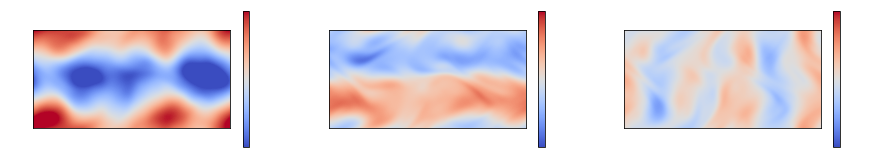

In [ ]:
imshow3(MLOceanEnsemble.estimate(np.mean))

In [ ]:
np.c_[(Y0 - Y0mean)[0], (Y1 - Y1mean)[0]], np.c_[(Y0 - Y0mean)[1], (Y1 - Y1mean)[1]]

(array([[ -41.01833221,  -48.50273583],
        [-253.38158519, -267.05775026],
        [  35.88273158,   26.36286654],
        [  82.85467954,  140.39748128],
        [  61.25295076,   41.33711356],
        [  79.40366049,   99.85431741],
        [   0.27444607,   40.76751878],
        [ 107.24276025,   59.50033106],
        [  23.90232007,   37.49409334],
        [  41.2928098 ,   16.42682289],
        [ -19.42643473,  -47.10899097],
        [ -65.90221484,  -15.2875849 ],
        [ -17.47628377,   -6.77424019],
        [-157.95987508, -208.23871666],
        [ -68.87569374,  -29.05496339],
        [  -6.9863596 ,  -33.16647268],
        [-118.82378259, -151.84912248],
        [ -73.88431896, -141.53898235],
        [ 114.27246266,  161.8686416 ],
        [ 172.16281865,  199.84370144],
        [  96.78689213,  144.03495672],
        [ -67.25878029,   10.02218639],
        [   2.55128859,  -58.26007264],
        [ -10.63379158,  -28.6957969 ],
        [  83.74763199,   57.62539821]])

/home/florianb/havvarsel/multilevelDA/doublejet/utils/DoubleJetPlot.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,3, figsize=(15,10))


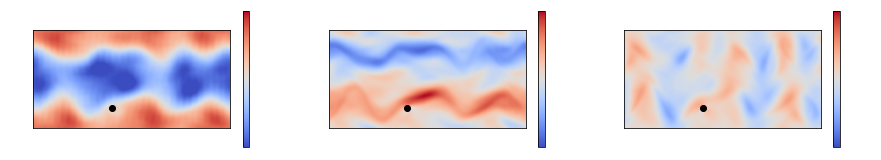

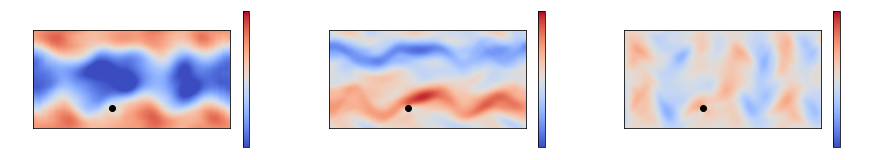

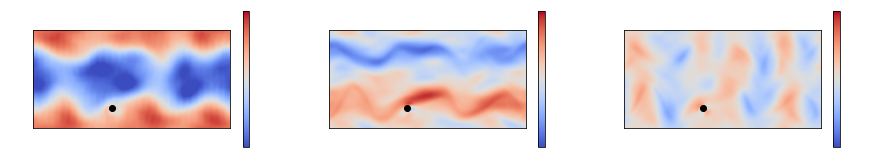

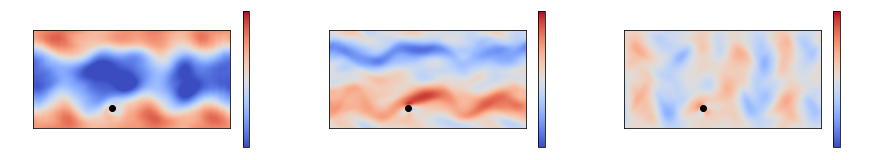

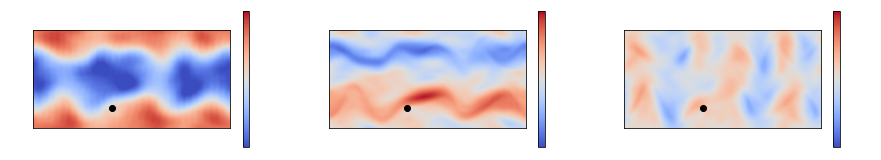

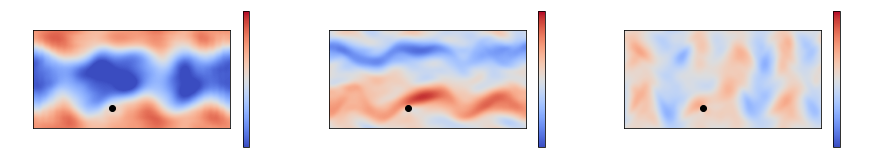

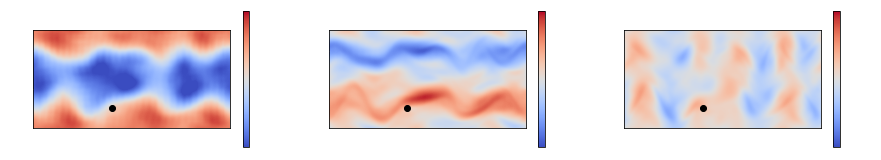

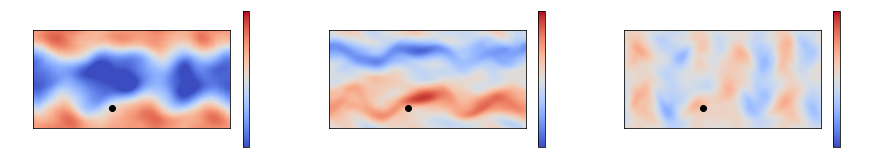

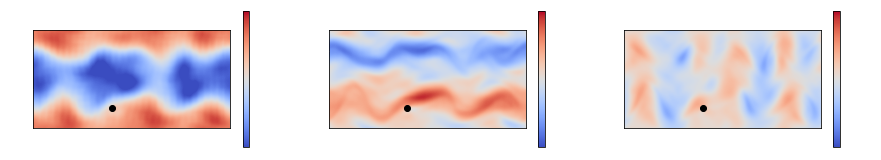

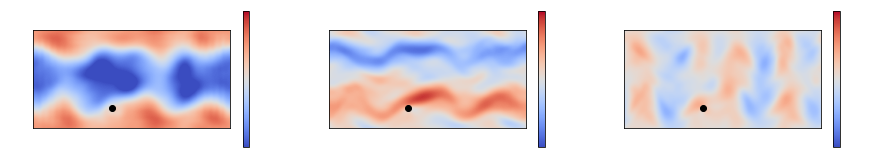

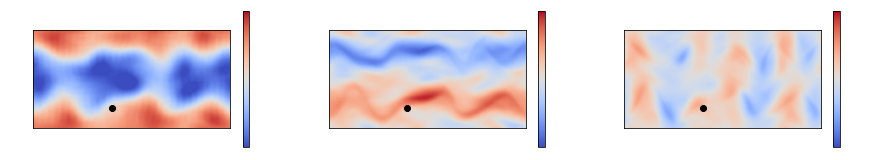

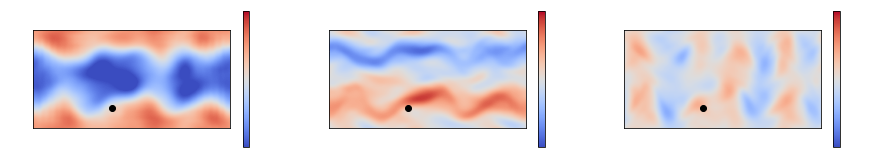

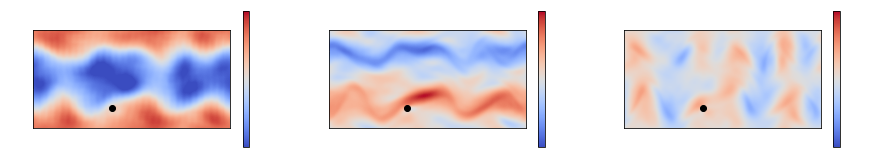

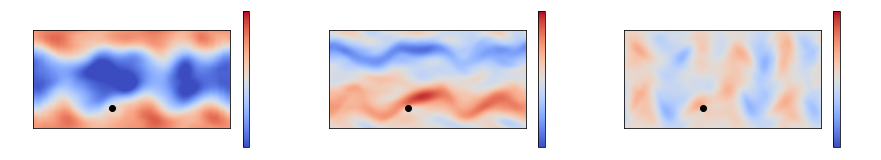

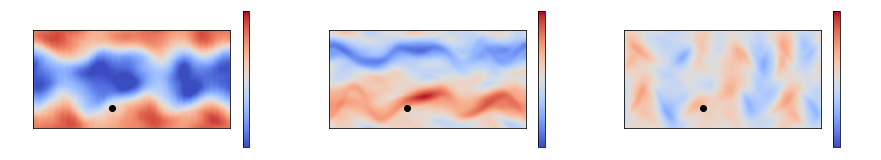

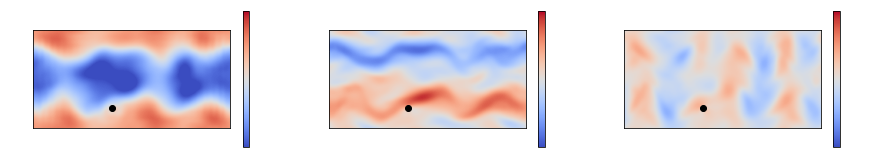

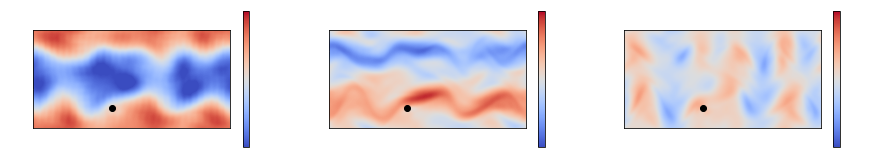

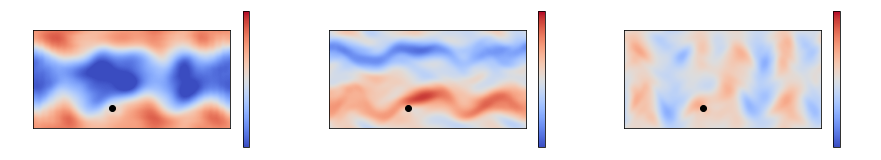

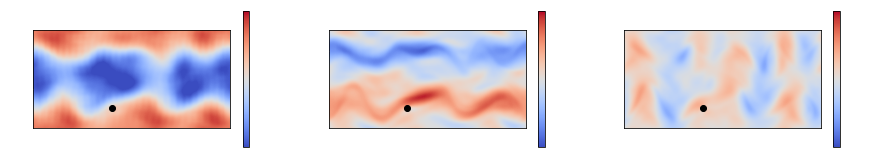

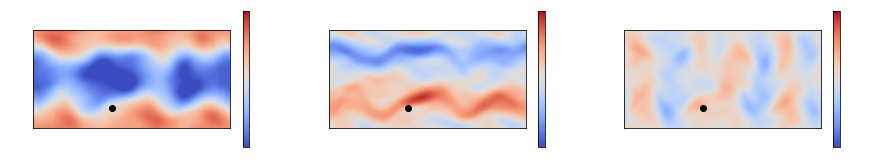

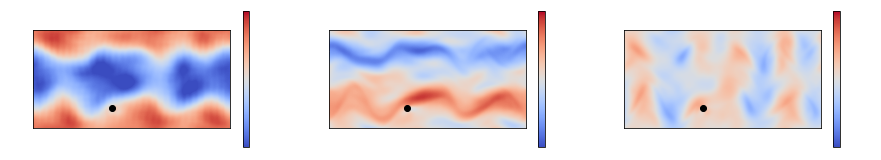

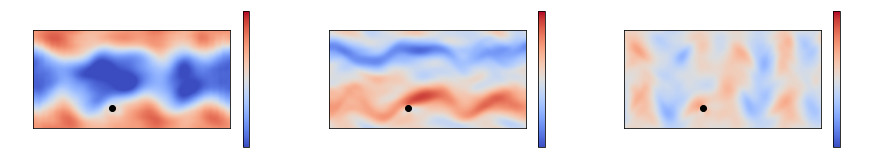

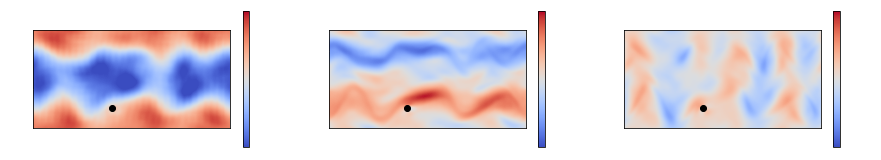

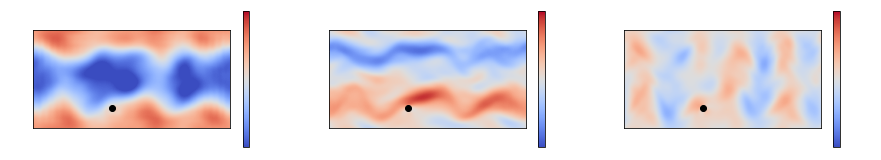

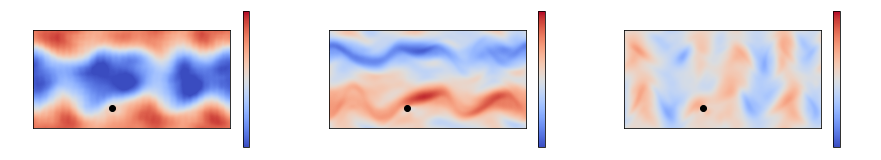

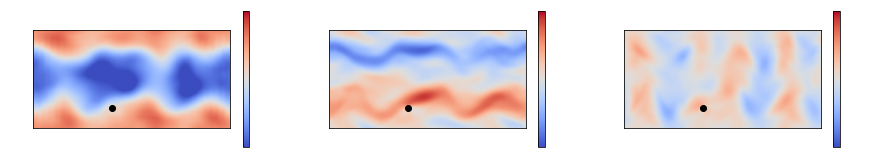

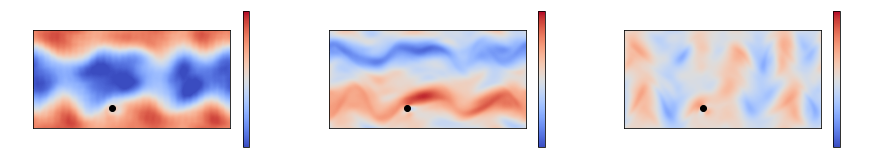

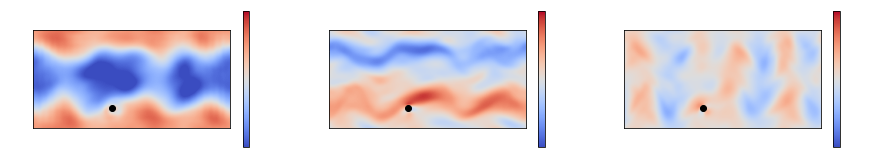

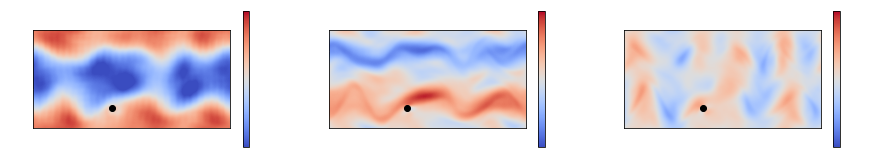

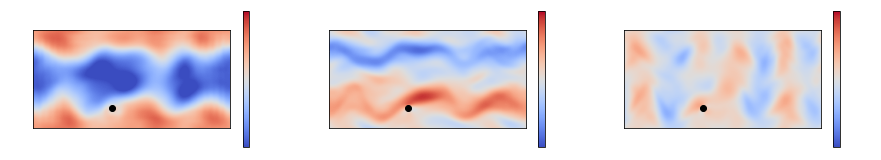

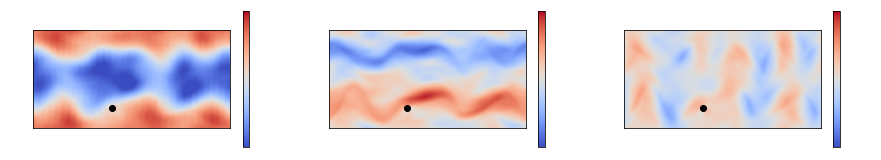

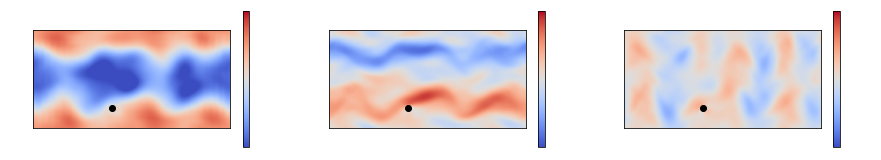

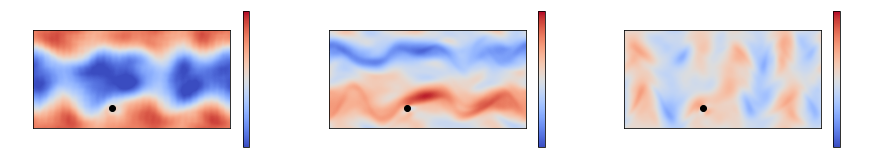

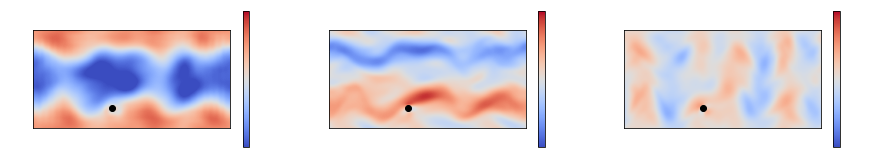

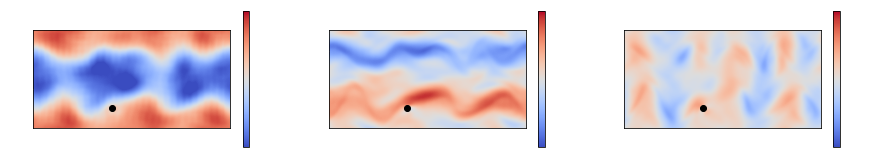

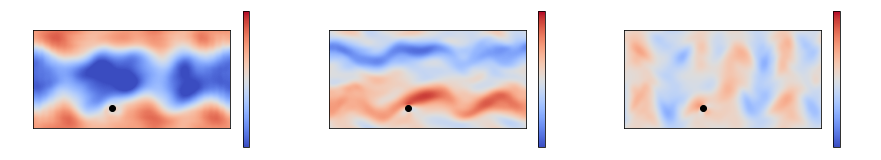

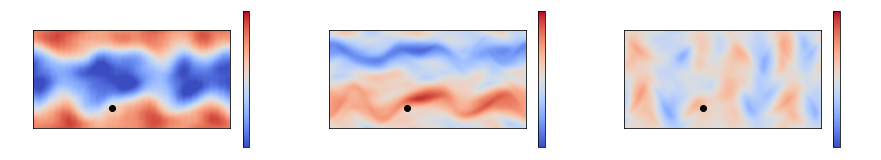

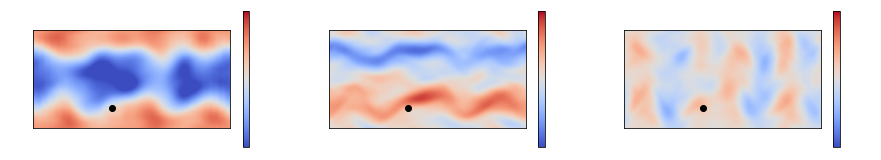

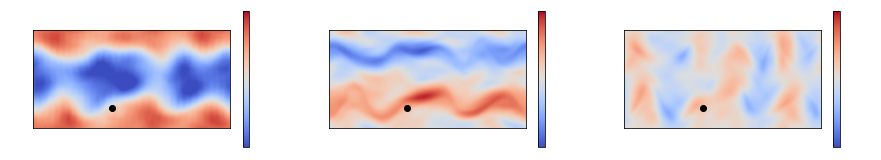

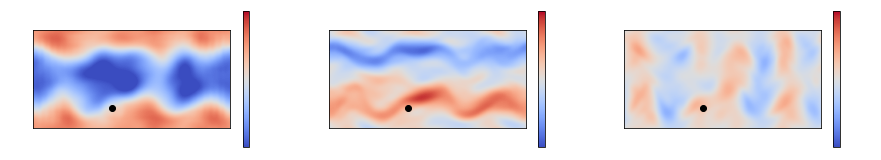

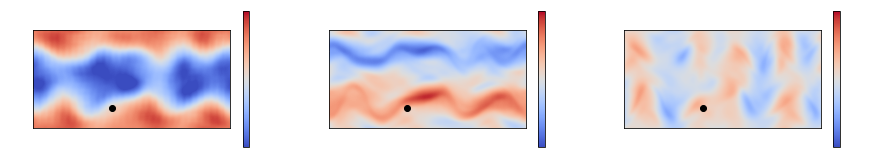

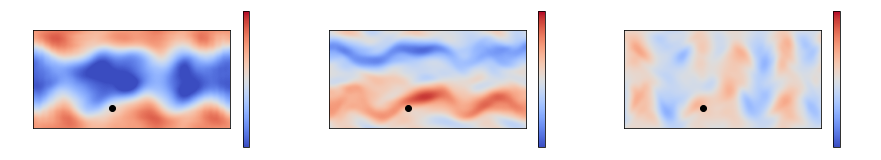

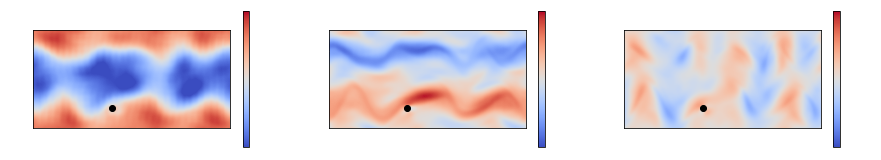

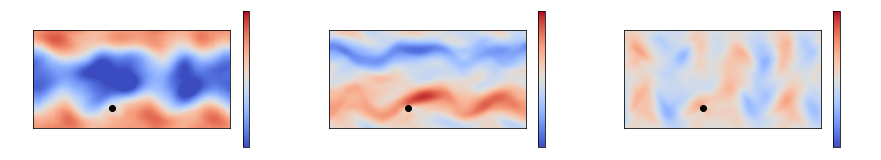

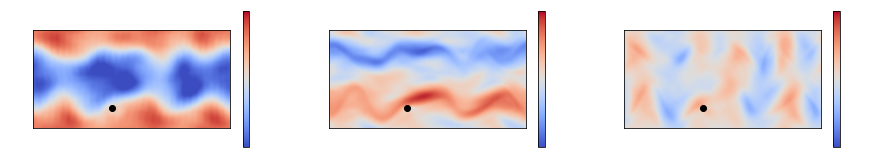

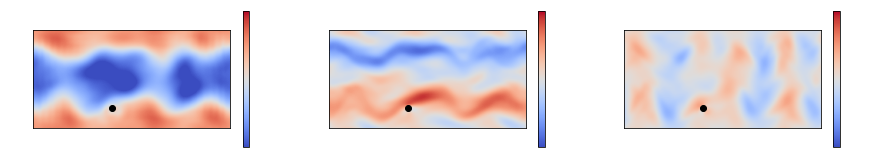

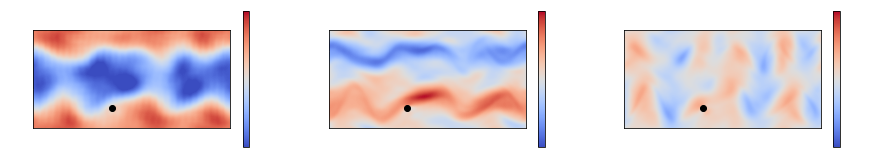

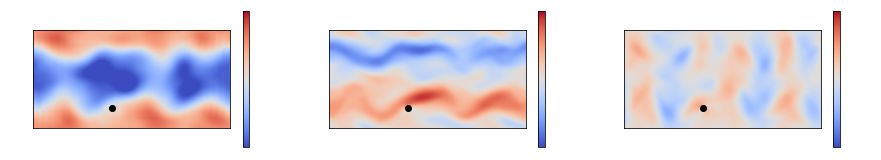

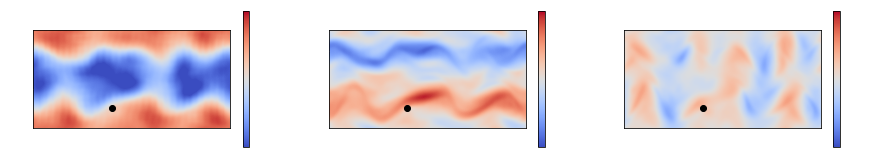

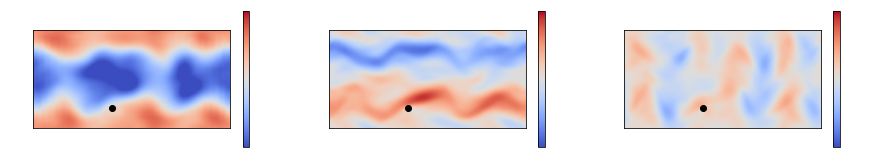

In [ ]:
for e in range(ML_Ne[1]):
    fig, axs = imshow3(ML_state[l_idx][0][:,:,:,e])
    for i in range(3):
        axs[i].scatter(obs_idxs[-1][0][1],obs_idxs[-1][0][0], c="black")

    fig, axs = imshow3(ML_state[l_idx][1][:,:,:,e])
    for i in range(3):
        axs[i].scatter(obs_idxs[-1][1][1],obs_idxs[-1][1][0], c="black")

In [ ]:
ML_YY + np.diag(R[obs_var])

array([[-1924.10616212,  -945.1003207 ],
       [ -945.1003207 ,   199.40415003]])

In [ ]:
np.linalg.eigvals(ML_YY + np.diag(R[obs_var]))

array([-2283.80752231,   559.10551022])

In [ ]:
for d_idx in range(obs_varN):
    print(ML_YY[d_idx,d_idx])
    if ML_YY[d_idx,d_idx] < 0.0:
        ML_YY[d_idx,d_idx] = 0.0

-2424.1061621160757
-300.59584997280206


In [ ]:
np.linalg.norm(np.linalg.inv(ML_YY + np.diag(R[obs_var]))), np.linalg.norm(np.linalg.inv(np.diag(R[obs_var])))

(0.002350839489484967, 0.00282842712474619)

In [ ]:
ML_YY + np.diag(R[obs_var])

array([[ 500.       , -945.1003207],
       [-945.1003207,  500.       ]])

In [ ]:
np.linalg.eigvals(ML_YY + np.diag(R[obs_var]))

array([1445.1003207, -445.1003207])

Analysis

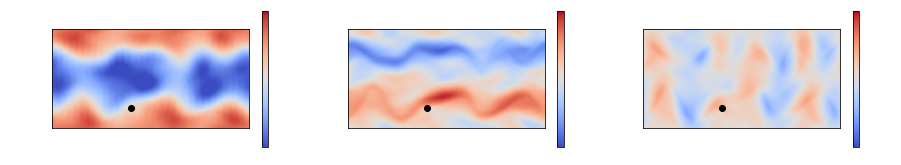

In [ ]:
extent = [0, MLOceanEnsemble.dxs[-1]*MLOceanEnsemble.nxs[-1], 0, MLOceanEnsemble.dys[-1]*MLOceanEnsemble.nys[-1]]

fig, axs = imshow3(MLOceanEnsemble.estimate(np.mean), extent=extent)
for i in range(3):
    axs[i].scatter(obs_xs[h], obs_ys[h], c="black")

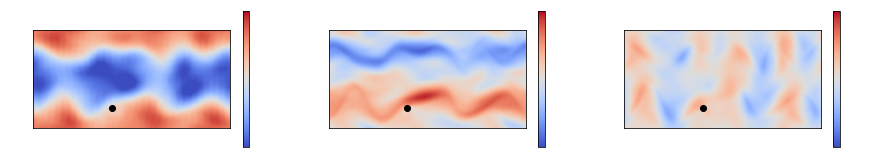

In [ ]:
fig, axs = imshow3(MLOceanEnsemble.estimate(np.mean))

for i in range(3):
    axs[i].scatter(obs_idxs[-1][0][1],obs_idxs[-1][0][0], c="black")

In [ ]:
h

21